<a href="https://colab.research.google.com/github/ShuichiroTsuda/Kaggle_Liverpool_Ion_Switching/blob/master/EDA_remove_data_drift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import os

def load_api_key():
    with open('/content/drive/My Drive/Colab Notebooks/Kaggle/API_setup/kaggle.json') as f:
        kaggle_api_key = json.load(f)
    
    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    with open(filename, 'w') as f:
        json.dump(kaggle_api_key, f)

    os.chmod(filename, 600)
    print('API key loaded.')

In [10]:
load_api_key()

API key loaded.


In [11]:
!kaggle datasets download -d cdeotte/data-without-drift

 89% 49.0M/55.0M [00:00<00:00, 52.1MB/s]
100% 55.0M/55.0M [00:00<00:00, 75.4MB/s]


In [12]:
!unzip data-without-drift.zip

Archive:  data-without-drift.zip
  inflating: test_clean.csv          
  inflating: train_clean.csv         


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
test = pd.read_csv('test_clean.csv')
train = pd.read_csv('train_clean.csv')
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


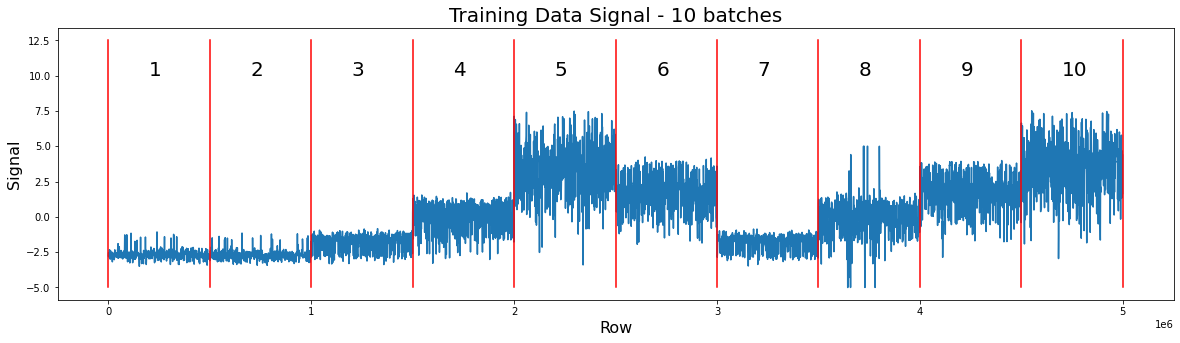

In [15]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

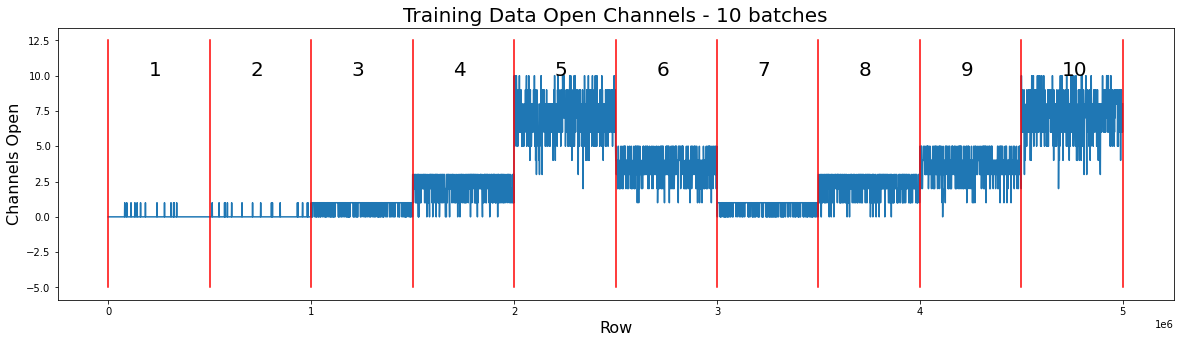

In [16]:
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Training Data Open Channels - 10 batches',size=20)
plt.show()

#########################
### Random 4383325 to 4388325
#########################


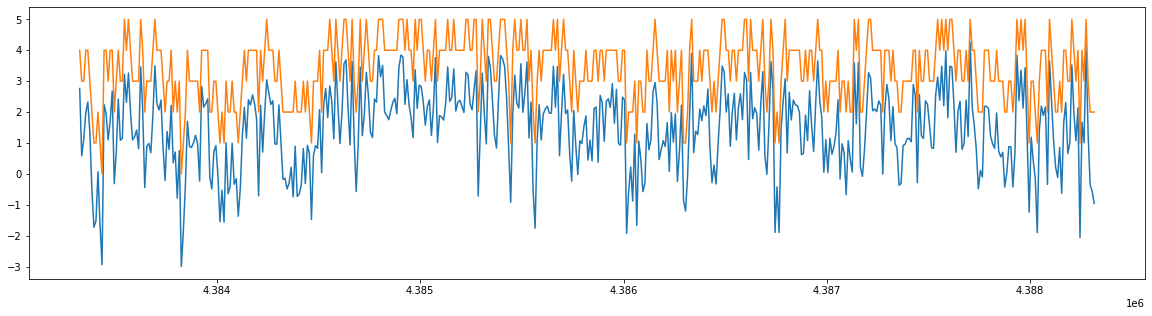

#########################
### Random 4584010 to 4589010
#########################


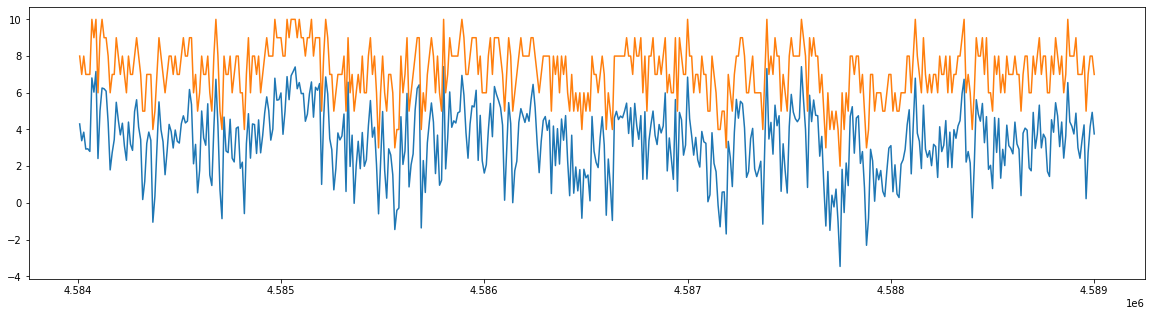

#########################
### Random 3733501 to 3738501
#########################


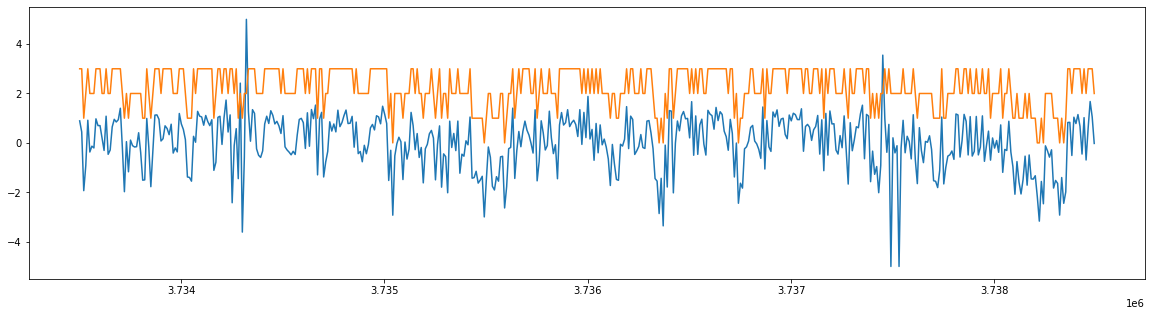

#########################
### Random 4792108 to 4797108
#########################


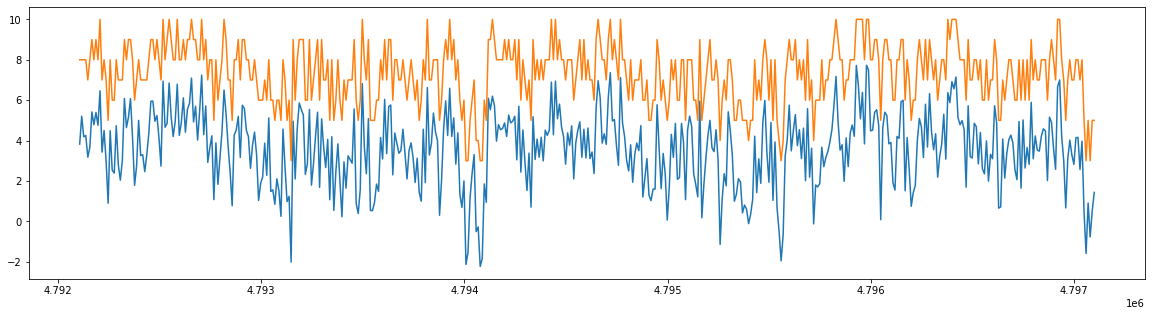

#########################
### Random 4154686 to 4159686
#########################


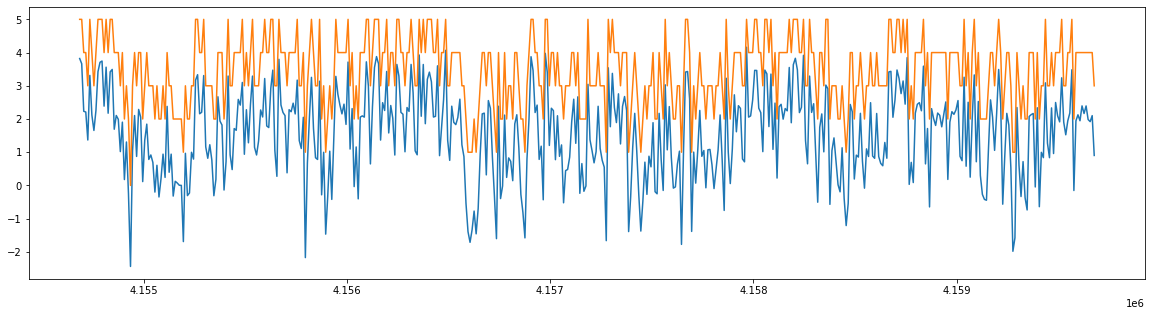

#########################
### Random 428366 to 433366
#########################


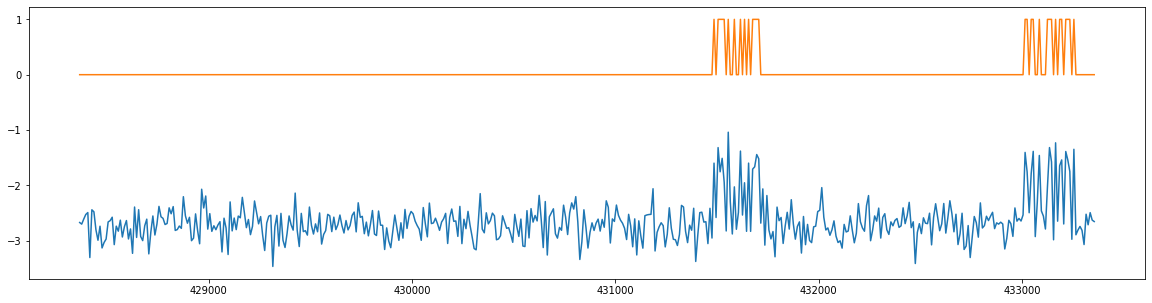

#########################
### Random 4613883 to 4618883
#########################


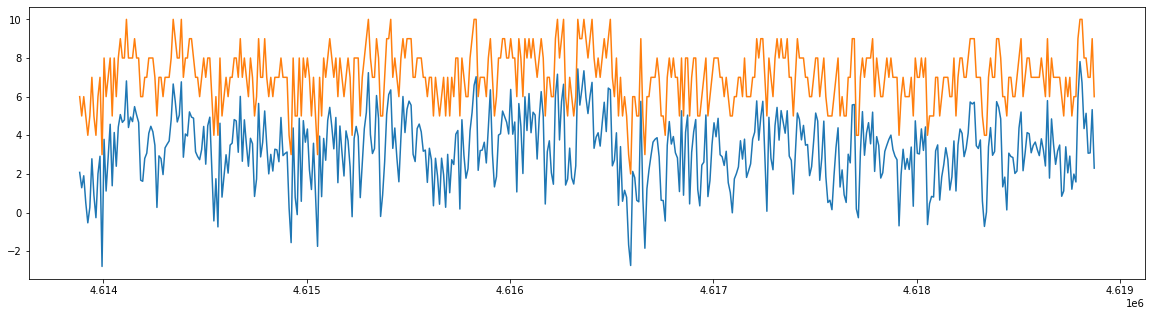

#########################
### Random 4106649 to 4111649
#########################


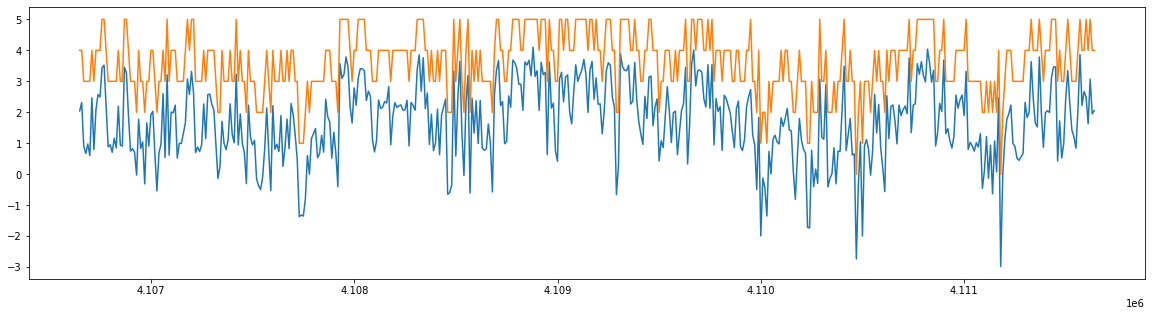

#########################
### Random 3319638 to 3324638
#########################


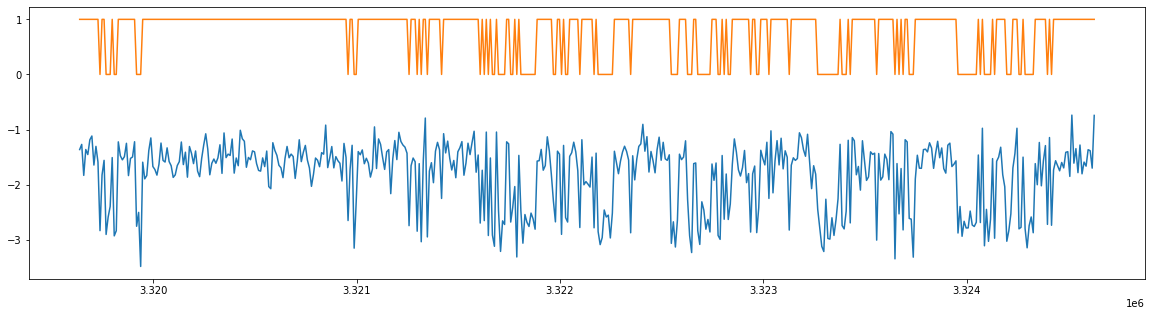

#########################
### Random 4269231 to 4274231
#########################


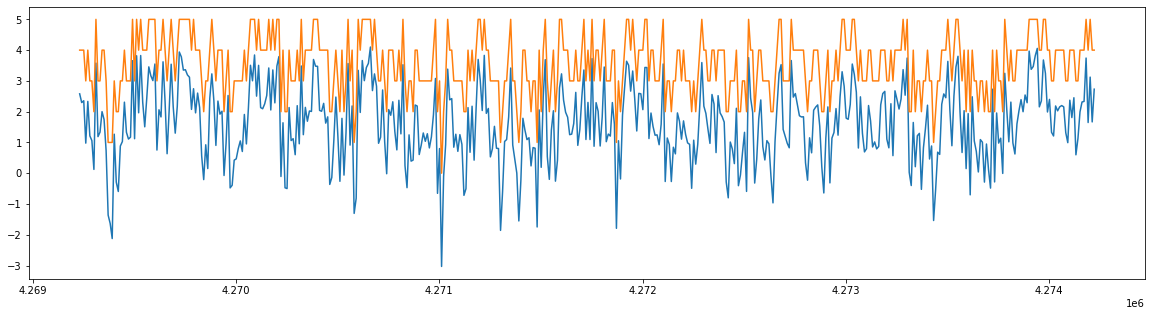

In [17]:
for k in range(10):
    a = int( np.random.uniform(0,train.shape[0]-50000) )
    b=a+5000; res=10
    print('#'*25)
    print('### Random %i to %i'%(a,b))
    print('#'*25)
    plt.figure(figsize=(20,5))
    plt.plot(range(a,b,res),train.signal[a:b][0::res])
    plt.plot(range(a,b,res),train.open_channels[a:b][0::res])
    plt.show()

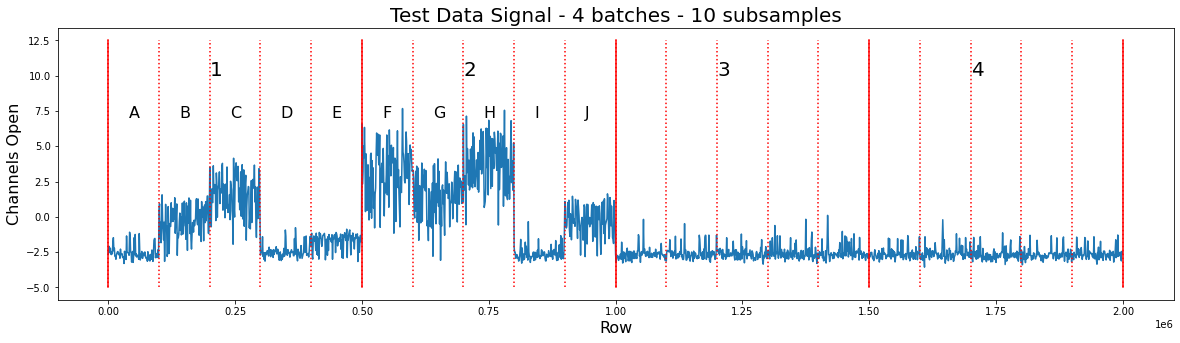

In [18]:
plt.figure(figsize=(20,5))
res = 1000; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0,test.shape[0],res),test.signal[0::res])
for i in range(5): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(21): plt.plot([j*100000,j*100000],[-5,12.5],'r:')
for k in range(4): plt.text(k*500000+200000,10,str(k+1),size=20)
for k in range(10): plt.text(k*100000+40000,7,let[k],size=16)
plt.xlabel('Row',size=16); plt.ylabel('Channels Open',size=16); 
plt.title('Test Data Signal - 4 batches - 10 subsamples',size=20)
plt.show()

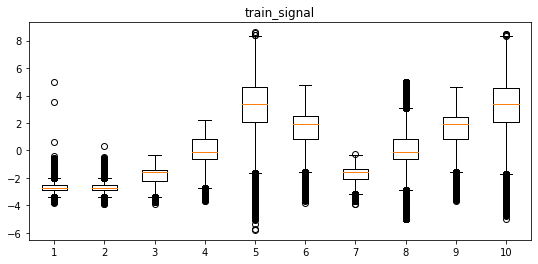

In [19]:
fig, axs = plt.subplots(figsize=(9, 4))
batch_train_signal = [train.signal[500000*i:500000*(i+1)] for i in range(0,10)]
axs.boxplot(batch_train_signal)
axs.set_title('train_signal')

plt.setp(axs, xticks=[y + 1 for y in range(len(batch_train_signal))])
plt.show()

batch_1 = [1, 2] 
batch_2 = [3, 7] 
batch_3 = [4, 8] 
batch_4 = [6, 9] 
batch_5 = [5, 10] 

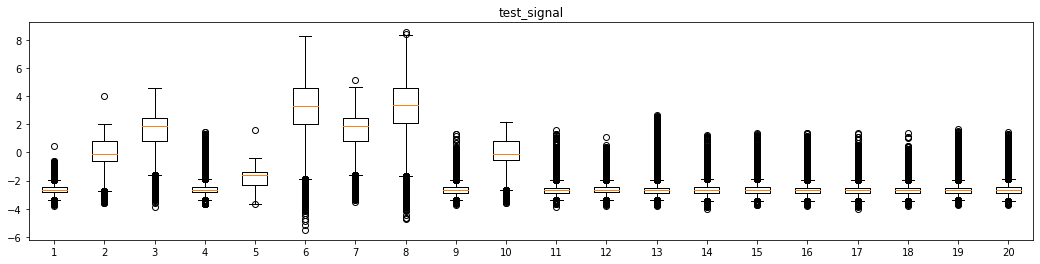

In [20]:
fig, axs = plt.subplots(figsize=(18, 4))
batch_test_signal = [test.signal[100000*i:100000*(i+1)] for i in range(0,20)]
axs.boxplot(batch_test_signal)
axs.set_title('test_signal')

plt.setp(axs, xticks=[y + 1 for y in range(len(batch_test_signal))])
plt.show()

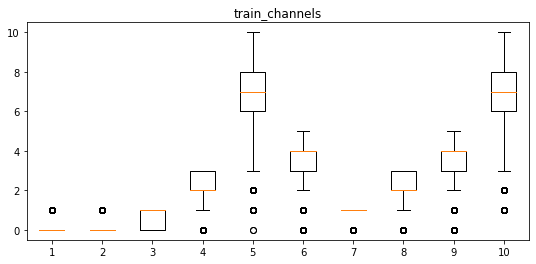

In [21]:
fig, axs = plt.subplots(figsize=(9, 4))
batch_train_channels = [train.open_channels[500000*i:500000*(i+1)] for i in range(0,10)]
axs.boxplot(batch_train_channels)
axs.set_title('train_channels')

plt.setp(axs, xticks=[y + 1 for y in range(len(batch_train_channels))])
plt.show()

In [0]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt,freqz
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from sklearn.model_selection import KFold

## Frequency Domain Analysis

In [0]:
batch_size = 500000
num_batches = 10
res = 1000 # Resolution of signal plots

fs = 10000       # sample rate, 10kHz
nyq = 0.5 * fs  # Nyquist Frequency
cutoff_freq_sweep = range(250,4750,50) # Sweeping from 250 to 4750 Hz for SNR measurement
lpf_cutoff = 600

In [0]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, cutoff_low, cutoff_high, fs, order):
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq    
    # Get the filter coefficients 
    b, a = butter(order, [normal_cutoff_low,normal_cutoff_high], btype='band', analog=False)
    y = filtfilt(b, a, data)
    return y

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])
/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x,

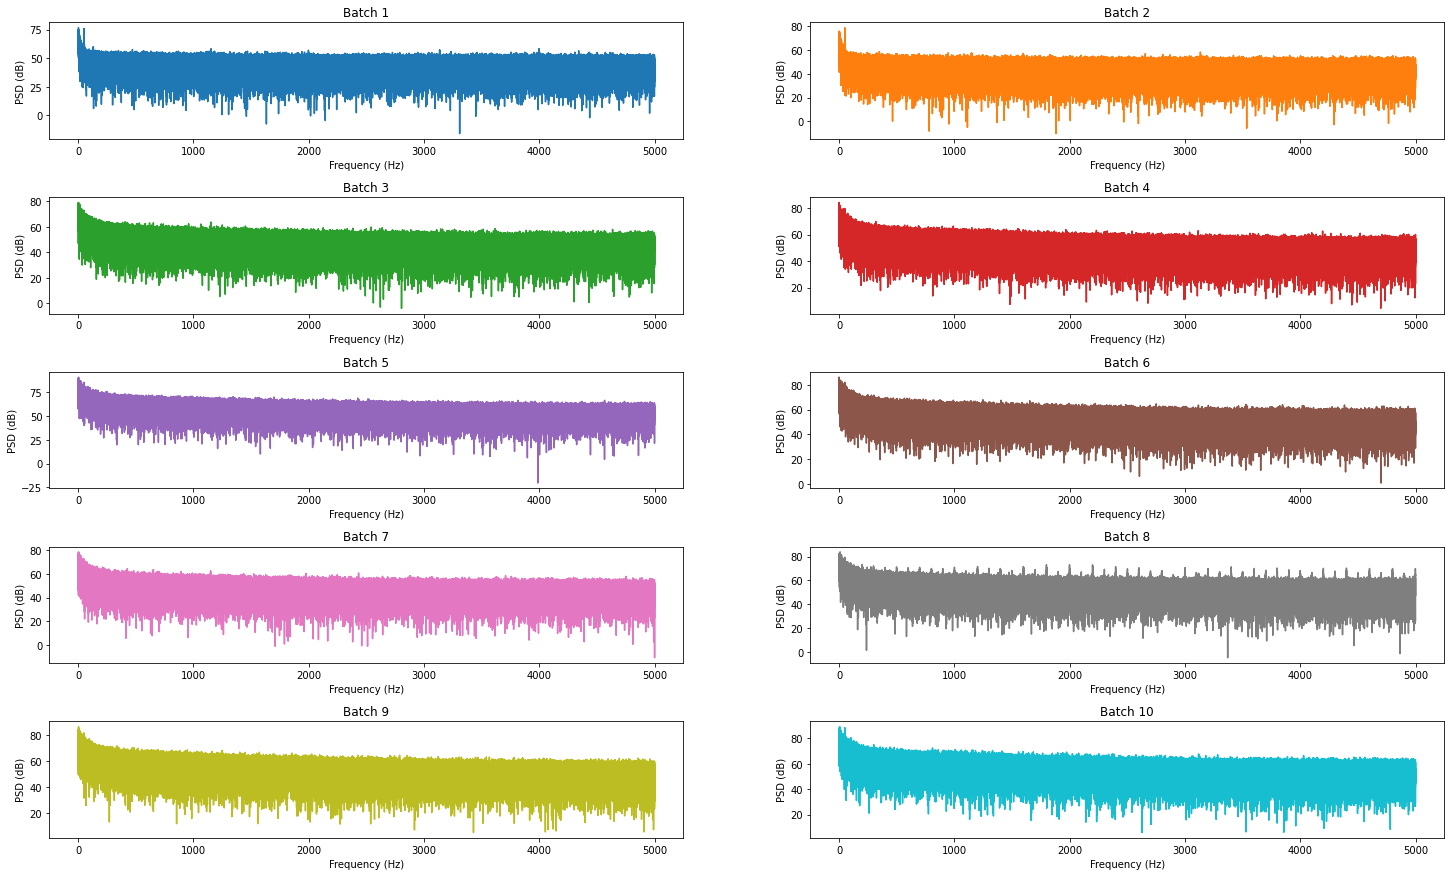

In [25]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25, 15))
fig.subplots_adjust(hspace = .5)
ax = ax.ravel()
colors = plt.rcParams["axes.prop_cycle"]()

for batch in range(num_batches):
    fft = sp.fftpack.fft(train.signal[batch_size*(batch):batch_size*(batch+1)])
    psd = np.abs(fft) ** 2
    fftfreq = sp.fftpack.fftfreq(len(psd),1/fs)
    i = fftfreq > 0
    
    c = next(colors)["color"]
    ax[batch].plot(fftfreq[i], 10 * np.log10(psd[i]),color=c)
    ax[batch].set_title(f'Batch {batch+1}')
    ax[batch].set_xlabel('Frequency (Hz)')
    ax[batch].set_ylabel('PSD (dB)')

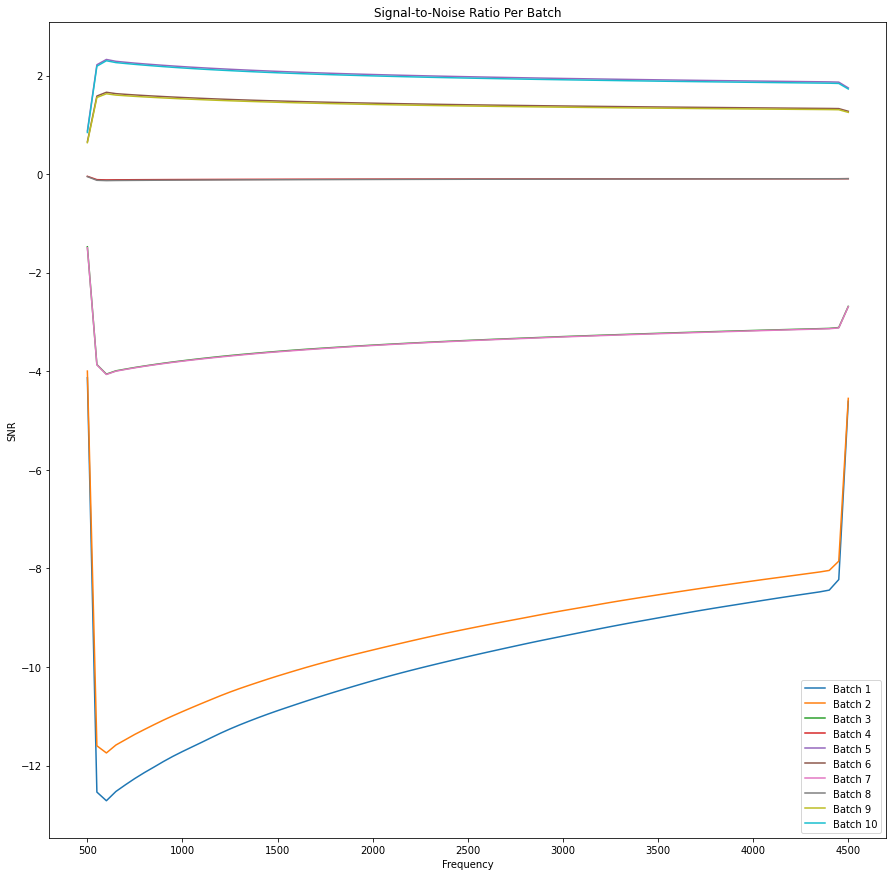

In [26]:
plt.figure(figsize=(15,15));

# Filter requirements.
order = 20
SNR = np.zeros(len(cutoff_freq_sweep))

for batch in range(num_batches):
    for index,cut in enumerate(cutoff_freq_sweep): 
        signal_lpf = butter_lowpass_filter(train.signal[batch_size*(batch):batch_size*(batch+1)], cut, fs, order)
        SNR[index] = signaltonoise(signal_lpf)
    
    plt.plot(cutoff_freq_sweep,SNR)

plt.title('Signal-to-Noise Ratio Per Batch')    
plt.xlabel('Frequency')
plt.ylabel('SNR')
plt.legend(['Batch 1','Batch 2','Batch 3','Batch 4','Batch 5','Batch 6','Batch 7','Batch 8','Batch 9','Batch 10',])

Text(0.5, 1.0, 'Low-pass Butterworth Filter, cutoff @ 600Hz')

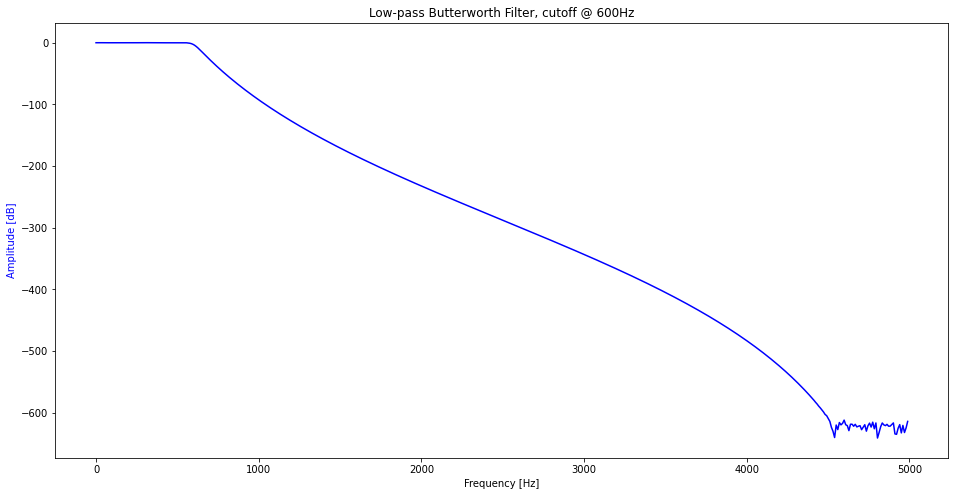

In [27]:
b, a = butter(order, lpf_cutoff/nyq, btype='low', analog=False)
w,h = freqz(b,a, fs=fs)

plt.figure(figsize=(16,8));
plt.plot(w, 20 * np.log10(abs(h)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.title('Low-pass Butterworth Filter, cutoff @ 600Hz')

/usr/local/lib/python3.6/dist-packages/scipy/fft/_pocketfft/helper.py:95: FutureWarning: Series.flags is deprecated and will be removed in a future version
  return np.array(x, copy=not x.flags['ALIGNED'])


Text(0.5, 1.0, 'Low pass filter - cutoff = 600 Hz')

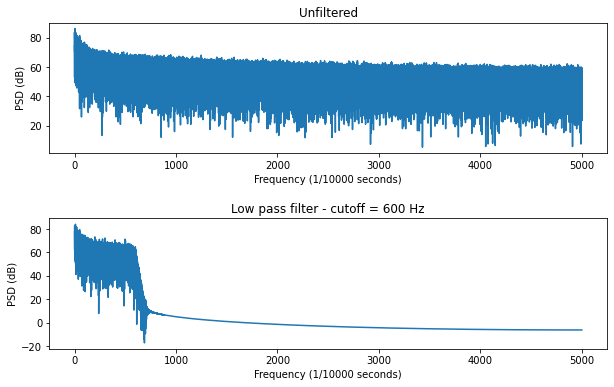

In [28]:
fft = sp.fftpack.fft(train.signal[batch_size*(batch-1):batch_size*batch])
psd = np.abs(fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(psd),1/fs)
i = fftfreq > 0

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
fig.subplots_adjust(hspace = .5)
ax[0].plot(fftfreq[i], 10 * np.log10(psd[i]))
ax[0].set_xlabel('Frequency (1/10000 seconds)')
ax[0].set_ylabel('PSD (dB)')
ax[0].set_title('Unfiltered')

batch = 8
signal_lpf_batch_8 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fft = sp.fftpack.fft(signal_lpf_batch_8)
psd = np.abs(fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(psd),1/fs)
i = fftfreq > 0

ax[1].plot(fftfreq[i], 10 * np.log10(psd[i]))
ax[1].set_xlabel('Frequency (1/10000 seconds)')
ax[1].set_ylabel('PSD (dB)')
ax[1].set_title('Low pass filter - cutoff = 600 Hz')

## Batch 1

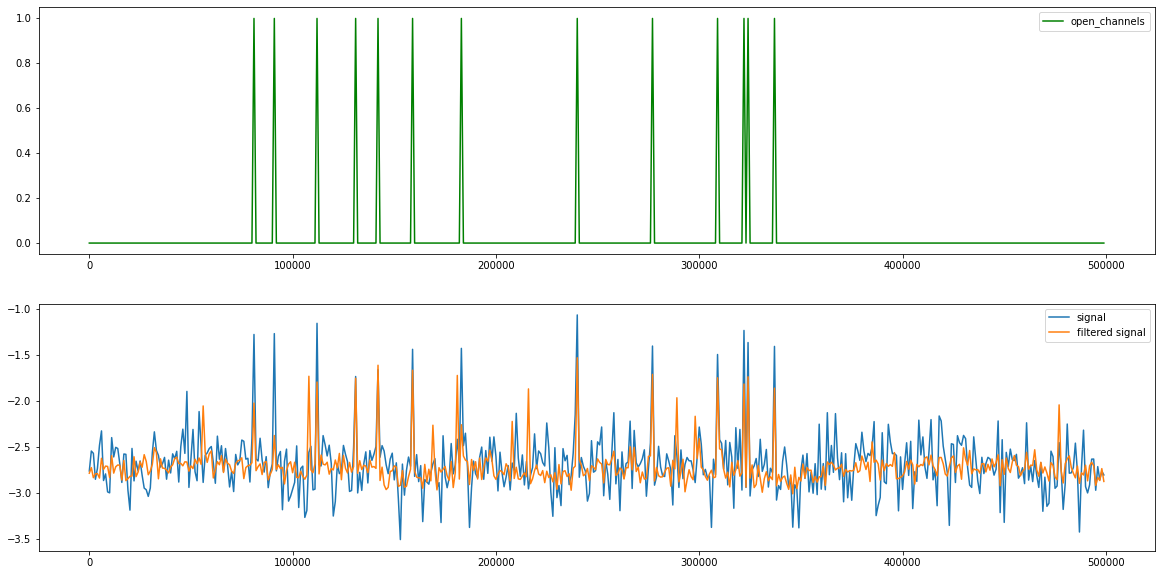

In [29]:
batch = 1
#hpf_cutoff = 10
signal_lpf_batch_1 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)
#signal_lpf_batch_1 = butter_bandpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], hpf_cutoff, lpf_cutoff, fs, order)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_1[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])

In [30]:
signal_lpf_batch_1

array([-2.78393261, -2.80404351, -2.82349373, ..., -2.79699767,
       -2.83750529, -2.87488559])

## Batch 2

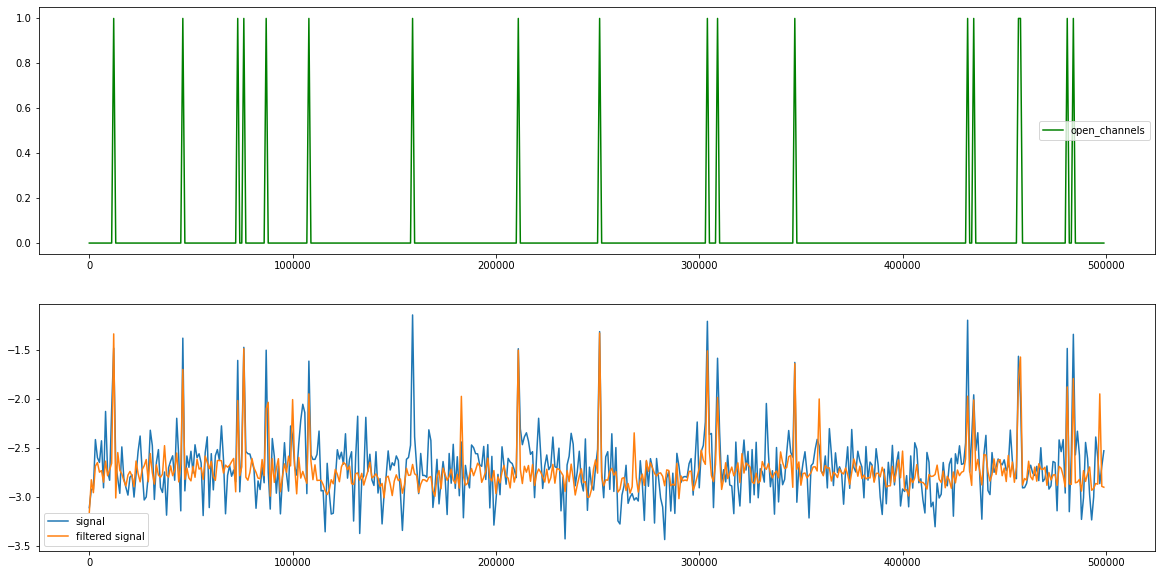

In [31]:
batch = 2

signal_lpf_batch_2 = butter_lowpass_filter(train.signal[batch_size*(batch-1):batch_size*batch], lpf_cutoff, fs, order)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(0,batch_size,res),train.open_channels[batch_size*(batch-1):batch_size*batch:res],color='g')
ax[1].plot(range(0,batch_size,res),train.signal[batch_size*(batch-1):batch_size*batch:res])
ax[1].plot(range(0,batch_size,res),signal_lpf_batch_2[::res])

ax[0].legend(['open_channels'])
ax[1].legend(['signal', 'filtered signal'])